In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [2]:
!pip install torch torchvision

    100% |████████████████████████████████| 484.0MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x5b798000 @  0x7f94a547d1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 16.6MB/s 
    100% |████████████████████████████████| 2.0MB 17.2MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.autograd import Variable
import torch.nn.functional as F

import urllib.request
import os, tarfile, zipfile
from glob import glob
import distutils
from distutils import dir_util

In [0]:
# workaround 
from PIL import Image
def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
Image.register_extension = register_extension
def register_extensions(id, extensions): 
  for extension in extensions: register_extension(id, extension)
Image.register_extensions = register_extensions

In [0]:
fruit360_URL = 'https://www.dropbox.com/s/ui10iyp9kwawlf3/fruits-360_dataset_2018_02_08.zip?dl=1'

## Load data

In [0]:
def fetch_data(URL, DOWNLOAD_FOLDER, DOWNLOAD_FILE):
  if not os.path.isdir(DOWNLOAD_FOLDER):
   os.makedirs(DOWNLOAD_FOLDER)
  
  if not os.path.isfile(DOWNLOAD_FOLDER+DOWNLOAD_FILE):
    print('Beginning file download...')
    urllib.request.urlretrieve(URL, DOWNLOAD_FOLDER+DOWNLOAD_FILE)
    print('Done.')
  

In [0]:
def split_train_test(XY, n_splits=1, test_size=0.2, random_state=42):
    split = StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
    for train_index, test_index in split.split(XY[0], XY[1]):
        X_train, Y_train = XY[0][train_index,:], XY[1][train_index]
        X_test, Y_test = XY[0][test_index,:], XY[1][test_index]
        
    return X_train, Y_train, X_test, Y_test

In [0]:
def mkdir(p):
    if not os.path.exists(p):
        os.makedirs(p)

def copy_dirs(src, dst):
    distutils.dir_util.copy_tree(src, dst)

def link(src, dest):
    if not os.path.exists(dest):
        os.c(src, dest, target_is_directory=True)

def make_small_dataset(train_path, valid_path, classes):
    train_path_from = os.path.abspath(train_path[0])
    valid_path_from = os.path.abspath(valid_path[0])

    train_path_to = os.path.abspath(train_path[1])
    valid_path_to = os.path.abspath(valid_path[1])
    
    mkdir(train_path_to)
    mkdir(valid_path_to)
    
    for c in classes:
        if not os.path.exists(train_path_to+'/'+c):
            copy_dirs(train_path_from+'/'+c, train_path_to+'/'+c)
        if not os.path.exists(valid_path_to+'/'+c):
            copy_dirs(valid_path_from+'/'+c, valid_path_to+'/'+c)

In [0]:
def get_fruit360_data(url, zip_folder, zip_file, extract_loc):
    
    fetch_data(url, zip_folder, zip_file)
    mkdir(extract_loc)
    zip_ref = zipfile.ZipFile(zip_folder+zip_file, 'r')
    zip_ref.extractall(extract_loc)
    zip_ref.close()
    

In [0]:
def one_hot_encoder(label):
    encoder = OneHotEncoder(dtype=np.float32)
    label_1hot = encoder.fit_transform(label.reshape(-1,1))
    print('The labels are: {}'.format(np.unique(label)))
    return label_1hot

In [0]:
root_folder = '/content/drive/app/'
# root_folder = 'D:/dev/data/'

In [12]:
get_fruit360_data(fruit360_URL, root_folder, 'fruits-360_dataset_2018_02_08.zip', root_folder+'large_set/')

Beginning file download...
Done.


In [0]:
classes = ['Apple Braeburn', 'Apple Golden 1', 'Apple Golden 2', 'Apple Golden 3', 'Apple Granny Smith', 'Apple Red 1', 'Apple Red 2', 'Apple Red 3', 'Apple Red Delicious', 'Apple Red Yellow', 'Apricot', 'Avocado', 'Avocado ripe', 'Banana', 'Banana Red', 'Cactus fruit', 'Carambula', 'Cherry', 'Clementine', 'Cocos', 'Dates', 'Granadilla', 'Grape Pink', 'Grape White', 'Grape White 2', 'Grapefruit Pink', 'Grapefruit White', 'Guava', 'Huckleberry']

train_path = [root_folder+'large_set/fruits-360/Training/', root_folder+'small_set_1/fruits-360/Training/']
valid_path = [root_folder+'large_set/fruits-360/Validation/', root_folder+'small_set_1/fruits-360/Validation/']

make_small_dataset(train_path=train_path, valid_path=valid_path, classes=classes)



In [49]:
!pwd
print(train_path[1])
print(valid_path[1])
# !ls -l 'drive/app/small_set/fruits-360/'
# !ls -l /content/drive/app/small_set_1/fruits-360/Training/
# !ls -l /content/drive/app/small_set_1/fruits-360/Validation/

# !ls -l /content/drive/app/small_set_1/fruits-360/Training/Avocado/

/content
/content/drive/app/small_set_1/fruits-360/Training/
/content/drive/app/small_set_1/fruits-360/Validation/


# Model definition

In [0]:
#@title Parameters
SELECTED = 0
train_folders = glob(train_path[SELECTED]+'/*')
train_images = glob(train_path[SELECTED]+'/*/*.jp*g')
valid_images = glob(valid_path[SELECTED]+'/*/*.jp*g')

IMAGE_SIZE = [100,100]
BATCH_SIZE = 32
EPOCHS = 16

In [15]:
train_dataset = datasets.ImageFolder(train_path[SELECTED], transform=transforms.ToTensor())
valid_dataset = datasets.ImageFolder(valid_path[SELECTED], transform=transforms.ToTensor())

print('Length of train dataset: {}'.format(len(train_dataset)))
print('Length of test dataset: {}'.format(len(valid_dataset)))

Length of train dataset: 28736
Length of test dataset: 9673


In [0]:
# batch_size = 100
# n_iters = 6000
# n_epochs = int(n_iters / (len(train_dataset)/batch_size))
# print('Number of epochs: {}'.format(n_epochs))


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [17]:
print('Length of test dataset: {}'.format(valid_dataset[0][0].size()))

Length of test dataset: torch.Size([3, 100, 100])


In [18]:
import collections
print(isinstance(train_loader, collections.Iterable), isinstance(valid_loader, collections.Iterable))

True True


## Display

In [0]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

[100, 100, 3] (100, 100, 3)


Text(0.5,1,'0')

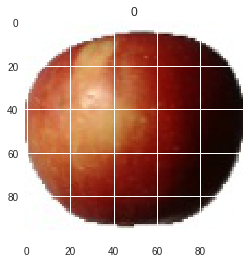

In [20]:
shape = list(train_dataset[0][0].size()[-2:])
show_img = train_dataset[0][0].numpy().transpose(1, 2, 0)
print(shape+[3], show_img.shape)
plt.imshow(show_img, cmap='gray')
# print(train_dataset[0][1])
plt.title(train_dataset[0][1])

## Build model

In [0]:
class CNN(nn.Module):
    def __init__(self, n_classes):
        super(CNN, self).__init__()
        
        
        self.conv11 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        self.conv21 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        self.conv31 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv32 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        self.conv41 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv42 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        
        
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.cnn3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.cnn4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
       
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        self.dropout2d = nn.Dropout2d(0.5)
        self.dropout = nn.Dropout(0.5)
        
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=n_classes)
            
                
    def forward(self, x):
        
        
        
        out = self.conv11(x)            # 32x100x100
        out = self.relu(out)
        out = self.conv12(out)          # 32x100x100
        out = self.relu(out)
        out = self.maxpool(out)         # 32x50x50
        
        out = self.conv21(out)            # 64x50x50
        out = self.relu(out)
        out = self.conv22(out)          # 64x50x50
        out = self.relu(out)
        out = self.maxpool(out)         # 64x25x25
        
        
        out = self.conv31(out)            # 128x25x25
        out = self.relu(out)
        out = self.conv32(out)          # 128x25x25
        out = self.relu(out)
        out = self.maxpool(out)         # 128x12x12
        
        
        out = self.conv41(out)            # 256x12x12
        out = self.relu(out)
        out = self.conv42(out)          # 256x12x12
        out = self.relu(out)
        out = self.maxpool(out)         # 256x6x6
        
        out = F.max_pool2d(out, kernel_size=out.size()[2:]) # GlobalMaxPooling 256x1x1
        
        out = out.view(out.size(0), -1) # 1x(256*1*1)
        out = self.fc1(out)
        out = self.fc2(out)
        
        
        
        return out
    
    
    def fit(self, train_loader, criterion, optimizer, epochs):
        iteration = 0
        for epoch in range(epochs):
            for i, (x, y) in enumerate(train_loader):
                # if torch.cuda.is_available():
                    # x = Variable(x.cuda(), volatile=True)
                    # y = Variable(y.cuda(), volatile=True)
                # else:
                x = Variable(x)
                y = Variable(y)

                optimizer.zero_grad()
                outputs = self.forward(x)
                #print(y.size())
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()

                iteration += 1

                if iteration%500 == 0:
                    print('Epoch: {}, Iteration: {}, Loss: {}'.format(epoch, iteration, loss))
                    #accuracy = predict(test_loader)
            
            
    
    
    def predict(self, test_loader):
        correct = 0
        total = 0
        first = True
        for x, y in test_loader:
            # if torch.cuda.is_available():
                # x = Variable(x.cuda(), volatile=True)
                # y = Variable(y.cuda(), volatile=True)
            # else:
            x = Variable(x)
            y = Variable(y)

            outputs = self.forward(x)
            if first == True:
              predicted = torch.argmax(outputs, dim=1)
              first = False
            else:
              predicted = torch.cat((predicted, torch.argmax(outputs, dim=1)))
            
        return predicted
        
    def score(self, target, predicted):
        correct = (predicted == target).sum()
        accuracy = np.round(100.*correct/total, 3)
        return accuracy

## Instatiate model

In [0]:
ann = CNN(len(train_folders))
# if torch.cuda.is_available():
#     ann.cuda()
#     print('using cuda...')

In [0]:
# for i, (x, y) in enumerate(train_loader):
img = train_dataset[0][0]
img = img.view([1, 3, 100, 100])
print(img.size())
output = ann.forward(img)
print(output.size())

## Instantiate loss class

In [0]:
criterion = nn.CrossEntropyLoss()

## model.parameters() explained

In [22]:
print(ann.parameters())
print(len(list(ann.parameters())))

for parameter in list(ann.parameters()):
    print(parameter.size())

<generator object Module.parameters at 0x7f792dd6d410>
26
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([256, 128, 3, 3])
torch.Size([256])
torch.Size([256, 256, 3, 3])
torch.Size([256])
torch.Size([32, 16, 3, 3])
torch.Size([32])
torch.Size([64, 32, 3, 3])
torch.Size([64])
torch.Size([128, 64, 3, 3])
torch.Size([128])
torch.Size([256, 256])
torch.Size([256])
torch.Size([60, 256])
torch.Size([60])


## Optimizer

In [0]:
learning_rate = 0.0001
optimizer=torch.optim.Adam(ann.parameters(), lr=learning_rate)

## Training phase

In [24]:
ann.fit(train_loader, optimizer=optimizer, criterion=criterion, epochs=EPOCHS)        

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:83: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Epoch: 0, Iteration: 500, Loss: 1.258507490158081
Epoch: 1, Iteration: 1000, Loss: 0.841778576374054
Epoch: 1, Iteration: 1500, Loss: 0.2365855872631073
Epoch: 2, Iteration: 2000, Loss: 0.05679132416844368
Epoch: 2, Iteration: 2500, Loss: 0.12860223650932312
Epoch: 3, Iteration: 3000, Loss: 0.012099198065698147
Epoch: 3, Iteration: 3500, Loss: 0.013637552037835121
Epoch: 4, Iteration: 4000, Loss: 0.007319100666791201
Epoch: 5, Iteration: 4500, Loss: 0.007442570757120848
Epoch: 5, Iteration: 5000, Loss: 0.0003351809864398092
Epoch: 6, Iteration: 5500, Loss: 0.0011569112539291382
Epoch: 6, Iteration: 6000, Loss: 0.0009021612931974232
Epoch: 7, Iteration: 6500, Loss: 0.000898420053999871
Epoch: 7, Iteration: 7000, Loss: 0.0908491313457489
Epoch: 8, Iteration: 7500, Loss: 0.23775677382946014
Epoch: 8, Iteration: 8000, Loss: 8.670103125041351e-05
Epoch: 9, Iteration: 8500, Loss: 6.976068834774196e-05
Epoch: 10, Iteration: 9000, Loss: 3.698368163895793e-05
Epoch: 10, Iteration: 9500, Loss: 7

## Prediction phase

In [0]:
predicted = ann.predict(test_loader)

In [0]:
print(predicted.size())

torch.Size([10000])


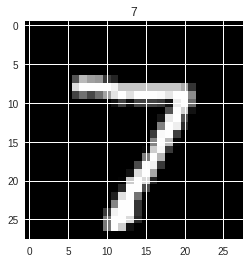

In [0]:
for images, labels in test_loader:
    images = Variable(images.view(-1, 28*28))
    labels = Variable(labels)
    
    plt.imshow(images[0].view(28,28).numpy(), cmap='gray')
    plt.title(labels[0].numpy())
    
    break

In [0]:
!kill -9 -1